<a href="https://colab.research.google.com/github/YMGYM/TSE_Learning/blob/master/Beijing_air_plollution_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

이 파일은 황철현, 신강욱의
`미세먼지 예측 성능 개선을 위한 CNN-LSTM 결합 방법`
논문의 구현 연습 파일입니다.

데이터셋은 [Beijing PM2.5 데이터셋](https://www.kaggle.com/djhavera/beijing-pm25-data-data-set)
을 사용했습니다.

# Import All
필요한 라이브러리들을 임포트합니다.

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Data
구글 드라이브를 마운트하고, 구글 드라이브에 있는 데이터를 임포트합니다.

In [2]:
! unzip /content/drive/My\ Drive/Datasets/beijing_air.zip -d data

Archive:  /content/drive/My Drive/Datasets/beijing_air.zip
  inflating: data/PRSA_data_2010.1.1-2014.12.31.csv  


In [3]:
def get_data():
  all_data = pd.read_csv('/content/data/PRSA_data_2010.1.1-2014.12.31.csv') # 전체 데이터
  dropped_data = all_data.drop(['No', 'year', 'month', 'day', 'hour'],axis=1) # 필요 없는 데이터는 버림
  pm25 = dropped_data.pop('pm2.5') # 미세먼지 데이터 확인
  pm25 = pm25.fillna(method='pad')
  
  return pm25, dropped_data

# Define Scalers
데이터를 정규화할 스케일러를 구현합니다.

In [4]:
class Scaler():
  def __init__(self):
    self.scaler = MinMaxScaler()
    self.last_scaled_data = None

  def data_normalize(self, data = None):
    if isinstance(data, type(np.array([]))) == False:
      reshaped = data.to_numpy().reshape(-1,1) # x 가 pandas 데이터인 경우 numpy로 변환 후 reshape 한다.
    else:
      reshaped = data.reshape(-1,1)

    self.last_scaled_data = self.scaler.fit_transform(reshaped)

    return self.last_scaled_data

  def invert_scale(self, data):
    # 정규화된 데이터를 원상태로 돌립니다.
    return self.scaler.inverse_transform(data)

  def slice_data(self, data, rate=0.1): # 데이터를 정해진 비율로 나눕니다.
    arrlen = int(len(data) * rate)
    train, val, test = data[:-1 * (arrlen * 2)], data[-1 * (arrlen * 2) : -1 * (arrlen)], data[-1 * (arrlen):]
    return train, val, test

## Pm2.5 Data Scaler
미세먼지 데이터를 위한 Scaler 구현입니다. 기능은 동일합니다.

In [5]:
class PmScaler(Scaler):
  def __init__(self):
    super().__init__()

## Proxy Data Scaler
주위 환경 정보용 Scaler 구현입니다.

In [6]:
class ProxyScaler(Scaler):
  def __init__(self):
    super().__init__()

  def change_cbwd_data(self, table): # 문자열로 된 풍향 정보를 숫자로 변환합니다.
    mapping = {}
    cols = table["cbwd"].value_counts().index
    for i, col in enumerate(cols):
      mapping[col] = i
    table = table.replace({'cbwd' : mapping})
    print("cbwd data changed to number : {SE : 0, NW: 1, cv: 2, NE:3} ")

    return table

  def data_normalize(self, data):
    norm_data = self.scaler.fit_transform(data)
    return norm_data
    

# Make Custom Layer (Not Used)
CNN 계층의 출력을 비율로 변환해주는 커스텀 계층입니다.

현재는 사용하지 않습니다.

In [7]:
class DataCombine(K.layers.Layer):
  def __init__(self, data, bins = None, **kwargs):
    super().__init__(**kwargs)

    if bins == None:
      self.bins = [-9.166667e-02, -1e-15,1e-15, 1.212121e-01]
    else:
      self.bins = bins

    self.grad_data = pm25.pct_change().fillna(method="pad")
    
  def call(self, inputs):
    # 예측량을 구함
    rate = self._get_rate(data)
    return rate * value.squeeze(axis=1)

  def _get_rate(self, data):
    # 변화율 별로 pm25의 예측량을 구해봄(임시)
    index = data.argmax(axis=1)
    rate = np.array([])
    for i in range(len(index)):
      if index[i] == 3:
        rate = np.append(rate, 1)
      else:
        rate = np.append(rate, 1 + ((index[i]-3) * 0.25)) # 최대 50%의 변화율을 줘 봄
    return rate

  def _get_grad_pm25(self):
    # pm25 의 변화율을 구하고 범주화함
    grad_data = self.pm25.pct_change()
    grad_data = grad_data.fillna(method="pad")
    bins = [-9.166667e-02, -1e-15,1e-15, 1.212121e-01]
    # bins = [-10, -1e-15, 1e-15, 10]
    grad_level = np.digitize(grad_data, bins=bins, right=False)
    return grad_level


# Custom Generator
데이터 제공을 위한 커스텀 제너레이터 구현

In [8]:
class CustomGenerator(K.utils.Sequence):
  def __init__(self, cnn_gen, lstm_gen):
    self.cnn_gen = cnn_gen
    self.lstm_gen = lstm_gen

  def __getitem__(self, idx):
    cnn_x, cnn_y = self.cnn_gen[idx]
    lstm_x, lstm_y = self.lstm_gen[idx]
  
    return [cnn_x, lstm_x], lstm_y

  def __len__(self):
    return self.cnn_gen.__len__() #위험!

# Make Model Trainer
모델을 학습시켜주는 Trainer 클래스입니다.

In [9]:
class ModelTrainer():
  def __init__(self, pm25, proxy):
    # --------- 데이터 보관 --------
    self.pm25 = pm25.fillna(1e-8,limit=1).fillna(method="pad")
    self.proxy = proxy
    print(f"pm25 length : {len(self.pm25)}" )
    print(f"proxydata length : {len(self.proxy)}" )

    # --------- 스케일러 생성 --------
    self.pmScaler = PmScaler()
    self.proxyScaler = ProxyScaler()

    # ---------- train 용 callbacks -----------
    self.callbacks = [K.callbacks.TensorBoard(log_dir='model_logs')]


  def data_preprocess(self, rate = 0.1): # 데이터 전처리
    self.proxy = self.proxyScaler.change_cbwd_data(self.proxy)
    # -------- 데이터 정규화 ---------
    self.pm25 = self.pmScaler.data_normalize(self.pm25)
    self.proxy = self.proxyScaler.data_normalize(self.proxy)
    # -------- 데이터 분할 ----------
    self.cnn_train, self.cnn_val, self.cnn_test = self.proxyScaler.slice_data(data=self.proxy, rate = rate)
    self.lstm_train, self.lstm_val, self.lstm_test = self.pmScaler.slice_data(data=self.pm25, rate = rate)
    print(f"cnn_x_train : {len(self.cnn_train)}, cnn_x_val : {len(self.cnn_val)}, cnn_x_test length: {len(self.cnn_test)}")
    print(f"lstm_x_train : {len(self.lstm_train)}, lstm_x_val : {len(self.lstm_val)}, lstm_x_test length: {len(self.lstm_test)}")

  def make_datagenerator(self, data_len = 15, batch_size = 1): # 데이터 제너레이터 생성

    self.cnn_train_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_train, self.cnn_train, length=data_len, batch_size = batch_size, shuffle=True)
    self.cnn_val_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_val, self.cnn_val, length=data_len, batch_size = batch_size, shuffle=True)
    self.cnn_test_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_test, self.cnn_test, length=data_len, batch_size = batch_size, shuffle=False)
    print(f"cnn_train_data_gen length : {self.cnn_train_data_gen.__len__()} // data_len: {data_len}" )
    print(f"cnn_val_data_gen length : {self.cnn_val_data_gen.__len__()} // data_len: {data_len}" )
    print(f"cnn_test_data_gen length : {self.cnn_test_data_gen.__len__()} // data_len: {data_len}" )

    self.lstm_train_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.lstm_train, self.lstm_train, length=data_len, batch_size = batch_size, shuffle=True)
    self.lstm_val_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.lstm_val, self.lstm_val, length=data_len, batch_size = batch_size, shuffle=True)
    self.lstm_test_data_gen = K.preprocessing.sequence.TimeseriesGenerator(self.lstm_test, self.lstm_test, length=data_len, batch_size = batch_size, shuffle=False)
    print(f"lstm_train_data_gen length : {self.lstm_train_data_gen.__len__()} // data_len: {data_len}" )
    print(f"lstm_val_data_gen length : {self.lstm_val_data_gen.__len__()} // data_len: {data_len}" )
    print(f"lstm_test_data_gen length : {self.lstm_test_data_gen.__len__()} // data_len: {data_len}" )

    self.total_train_data_gen = CustomGenerator(self.cnn_train_data_gen, self.lstm_train_data_gen)
    self.total_val_data_gen = CustomGenerator(self.cnn_val_data_gen, self.lstm_val_data_gen)
    self.total_test_data_gen = CustomGenerator(self.cnn_test_data_gen, self.lstm_test_data_gen)
    print("total data generator generated")

  def generate_model(self): # 모델을 생성함
    cnn_x, cnn_y = self.cnn_train_data_gen[0]
    lstm_x, lstm_y = self.lstm_train_data_gen[0]

    cnn_input = K.layers.Input(shape=(cnn_x.shape[1], cnn_x.shape[2])) # (행, 열)
    lstm_input = K.layers.Input(shape=(lstm_x.shape[1], lstm_x.shape[2])) # (시간 수, 1)

    reshape1 = K.layers.Reshape(target_shape=(1, cnn_x.shape[1], cnn_x.shape[2]))(cnn_input) #(배치, 차원 = 1, 행, 열)
    cnn1 = K.layers.Conv2DTranspose(32, (2,2), activation="relu")(reshape1)
    maxpool1 = K.layers.MaxPool2D(strides=2)(cnn1)
    flatten = K.layers.Flatten()(maxpool1)
    dropout1 = K.layers.Dropout(0.1)(flatten)
    dense1 = K.layers.Dense(100, activation="relu")(dropout1)
    dense2 = K.layers.Dense(1, activation="sigmoid")(dense1)

    reshape2 = K.layers.Reshape(target_shape=(-1, 1))(dense2) # (결과 값 수 , 1)
    concat = K.layers.Concatenate(axis=1)([lstm_input, reshape2])

    lstm1 = K.layers.LSTM(216)(concat)
    dropout2 = K.layers.Dropout(0.3)(lstm1)
    dense3 = K.layers.Dense(128, activation='relu')(dropout2)
    dropout3 = K.layers.Dropout(0.3)(dense3)
    dense4 = K.layers.Dense(1, activation="sigmoid")(dropout3)

    self.model = K.models.Model(inputs=[cnn_input,lstm_input] , outputs=dense4)
    self.model.summary()

    self.model.compile(loss="MSE", optimizer = "adam")
    return self.model

  def fit(self, epochs=1): # 모델 학습
    self.model.fit(x = self.total_train_data_gen, epochs=epochs, shuffle=True, validation_data=(self.total_val_data_gen), callbacks=self.callbacks)

  def evaluate(self): #테스트 데이터로 모델 평가
    self.model.evaluate(x = self.total_test_data_gen,)

  def predict(self, data = None): # 데이터 입력받아 예측함 => 클래스 밖에서도 model.fit 으로 호출 가능
    if data is None:
      data = self.total_test_data_gen

    prediction = self.model.predict(data)
    return self.pmScaler.invert_scale(prediction)

  def plot(self): # 그래프로 그립니다.
    predict = self.predict()
    plt.plot(self.pmScaler.invert_scale(self.lstm_test), label="Actual")
    plt.plot(predict, label="Predicted")
    plt.legend()
    plt.title("Compare Predict With Actual Data")
    plt.show()

  def load_model(self, path): # 저장된 모델을 불러옵니다.
    self.model = K.models.load_model(path)
    print(f"model loaded from {path}")
    return self.model

  def save_model(self, path): # 모델을 
    self.model.save(path)
    print(f"model saved at {path}")

논문에선 CNN 출력값을 범주화하고, 실제 예측값에 곱해서 변화량을 예측하는 데 사용했습니다.

하지만 이 구현에선 위 과정을 생략하고 CNN 의 출력값을 sigmoid로 단순히 변화시켜 값을 예측했습니다.

# 실제 코드 실행

미세먼지 데이터와 대기 환경 데이터를 한 번에 불러 옵니다.

In [10]:
pm25, proxy = get_data()

ModelTrainer 클래스를 생성합니다.

위에서 작업한 코드를 모두 불러옵니다.

In [11]:
trainer = ModelTrainer(pm25, proxy)

pm25 length : 43824
proxydata length : 43824


기존에 가지고 있던 데이터를 가지고 결측치 제거, 정규화, 분할을 수행합니다.

rate는 데이터를 학습, 검증, 테스트 데이터로 나누는 비율을 의미합니다.

In [12]:
trainer.data_preprocess(rate=0.1)

cbwd data changed to number : {SE : 0, NW: 1, cv: 2, NE:3} 
cnn_x_train : 35060, cnn_x_val : 4382, cnn_x_test length: 4382
lstm_x_train : 35060, lstm_x_val : 4382, lstm_x_test length: 4382


만들어 둔 데이터를 가지고 Datagenerator 를 생성합니다.

data_len은 얼마만큼의 시간 길이를 쓸 것인가를 의미합니다.

In [13]:
trainer.make_datagenerator(data_len = 15, batch_size = 128)

cnn_train_data_gen length : 274 // data_len: 15
cnn_val_data_gen length : 35 // data_len: 15
cnn_test_data_gen length : 35 // data_len: 15
lstm_train_data_gen length : 274 // data_len: 15
lstm_val_data_gen length : 35 // data_len: 15
lstm_test_data_gen length : 35 // data_len: 15
total data generator generated


모델을 생성합니다.

In [14]:
model = trainer.generate_model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 15, 7)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 2, 16, 32)    928         reshape[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1, 8, 32)     0           conv2d_transpose[0][0]           
_______________________________________________________________________________________

모델을 학습시키거나, 이미 저장된 가중치를 불러옵니다.

In [43]:
trainer.fit(epochs=100)
# trainer.load_model('/content/drive/My Drive/trained_model/AirPollution3')

Epoch 1/100
274/274 [==============================] - 2s 6ms/step - loss: 5.4711e-04 - val_loss: 6.3448e-04
Epoch 2/100
274/274 [==============================] - 2s 7ms/step - loss: 5.5333e-04 - val_loss: 6.6912e-04
Epoch 3/100
274/274 [==============================] - 2s 7ms/step - loss: 5.2680e-04 - val_loss: 5.5604e-04
Epoch 4/100
274/274 [==============================] - 2s 6ms/step - loss: 5.4694e-04 - val_loss: 6.2246e-04
Epoch 5/100
274/274 [==============================] - 2s 7ms/step - loss: 5.1496e-04 - val_loss: 6.3353e-04
Epoch 6/100
274/274 [==============================] - 2s 7ms/step - loss: 4.8891e-04 - val_loss: 6.1799e-04
Epoch 7/100
274/274 [==============================] - 2s 6ms/step - loss: 5.0080e-04 - val_loss: 6.2009e-04
Epoch 8/100
274/274 [==============================] - 2s 6ms/step - loss: 5.1819e-04 - val_loss: 8.6814e-04
Epoch 9/100
274/274 [==============================] - 2s 6ms/step - loss: 5.1098e-04 - val_loss: 7.6009e-04
Epoch 10/100
274/27

모델이 올바르게 학습되었는가를 확인하는 코드입니다.


In [44]:
trainer.evaluate()

35/35 [==============================] - 0s 4ms/step - loss: 3.8967e-04


실제 모델이 미세먼지 값을 예측합니다.

인자로 아무 것도 주어지지 않으면 ModelTrainer 클래스의 테스트 데이터로 작업을 수행합니다.

In [ ]:
result = trainer.predict()

ModelTrainer 클래스의 테스트 데이터를 가지고 실제 데이터와 비교해 그래프를 그립니다.

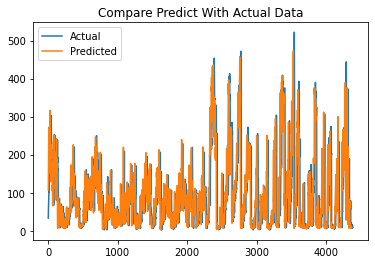

In [45]:
trainer.plot()

In [42]:
# trainer.save_model('/content/drive/My Drive/trained_model/AirPollution3-1')

INFO:tensorflow:Assets written to: /content/drive/My Drive/trained_model/AirPollution3-1/assets
model saved at /content/drive/My Drive/trained_model/AirPollution3-1


# Tensorboard
텐서보드는 모델의 학습 상황을 실시간으로 나타내는 익스텐션입니다.

오차율 변동 사항을 에포크 별로 확인이 가능합니다.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {'model_logs'}

# 시연
위에서 가져 온 베이징 데이터로 작업을 수행합니다.

현재 43824개의 데이터가 존재합니다.

In [76]:
pm25, proxy = get_data()
print(f"proxy data len : {len(proxy)}, pm25 data len {len(pm25)}")

proxy data len : 43824, pm25 data len 43824


Pandas 데이터 자료형을 Numpy 배열로 변경하겠습니다.

In [77]:
np_pm25 = pm25.to_numpy()
np_proxy = proxy.to_numpy()

이중에서 랜덤으로 하나를 골라 계측값을 확인하겠습니다.

4382개의 Test데이터가 있었으므로 이 중에서 하나를 측정합니다.

In [78]:
import random
idx = random.randint(4382, len(np_pm25))
print(f"idx : {idx}, proxy[-idx]: {np_proxy[-idx]}, pm25[-idx]: {np_pm25[-idx]}")

idx : 24841, proxy[-idx]: [1 2.0 1025.0 'SE' 5.81 0 2], pm25[-idx]: 278.0


데이터를 전처리합니다.

In [79]:
pmScaler = PmScaler()
proxyScaler = ProxyScaler()

norm_pm25 = pmScaler.data_normalize(data = np_pm25)
changed_proxy = proxyScaler.change_cbwd_data(proxy)
norm_proxy = proxyScaler.data_normalize(data = changed_proxy)

cbwd data changed to number : {SE : 0, NW: 1, cv: 2, NE:3} 


모델 트레이너 클래스를 생성하고, 모델을 불러 옵니다.

In [80]:
trainer = ModelTrainer(pm25, proxy) # 인자는 기존 학습의 잔재입니다.
trainer.load_model('/content/drive/My Drive/trained_model/AirPollution3')

pm25 length : 43824
proxydata length : 43824
model loaded from /content/drive/My Drive/trained_model/AirPollution3


시간 축 데이터가 15단위이므로, idx의 15시간 전 데이터를 넣겠습니다.

배치 사이즈가 1이므로 첫 번째 차원을 1로 변경합니다.(reshape)

In [81]:
input_proxy = norm_proxy[-idx - 16 : -idx-1].reshape(1,15,-1)
input_pm25 = norm_pm25[-idx - 16 : -idx-1].reshape(1,15,-1)

In [82]:
print(input_proxy.shape)
print(input_pm25.shape)

(1, 15, 7)
(1, 15, 1)


모델을 사용해 예측합니다.

두 개의 입력을 array 로 입력해 주어야 합니다. ([cnn_input, lstm_input])의 모양

In [83]:
prediction = trainer.model.predict([input_proxy, input_pm25])

정규화 한 값을 원래 값으로 되돌립니다.

In [84]:
invert_prediction = pmScaler.invert_scale(prediction)

값을 확인합니다.

In [85]:
print(f"Prediction value : {invert_prediction[0][0]}, Actual value : {np_pm25[-idx]}")

Prediction value : 240.63742065429688, Actual value : 278.0
